In [19]:
import pandas as pd
import numpy as np


####solver
from scipy.optimize import fsolve


import matplotlib.pyplot as plt
%matplotlib inline

# Bespoke module
from short_interest_rate import HoLee, BlackDermanToy, Option_IR
from binomial_plot import GraphTree


# Testing

## Data
I will be using data from "Fixed Income Securities" by Pietro Veronesi
The examples are taken from chapter 11.

In [3]:
# Table 10.11 Zero Coupon Bond Prices on January 8, 2002,
# Source The Wall Street Journal
# Taken from Fixed Income Securities - Pietro Veronesi || p.370


maturity = np.arange(0.5,6.0,0.5)

price = [99.1338, 97.8925, 96.1462,
         94.1011, 91.7136, 89.2258,
         86.8142, 84.5016, 82.1848,
         79.7718, 77.4339]

yield_ = [1.74, 2.13, 2.62, 3.04,
          3.46,3.8,4.04,4.21,4.36, 
          4.52,4.65]
sigma_hl = 0.0173
sigma_bdt = 0.2142
df = pd.DataFrame([maturity, price, yield_]).T
df.columns = ["Maturity", "Price", "Yield"]

In [4]:
zcb_02 = [i/100 for i in price]

#### Table: 11.2; p 384

In [5]:
# Theta from book
theta_hl = [0.015674,0.021824,0.014374,0.017324,0.007873,0.000423,-0.000628,0.004322,0.009271,0.001202]
theta_bdt = [0.7182,  0.6916, 0.3348, 0.3379, 0.1182, -0.023, -0.0438, 0.0455, 0.1281, -0.0126]


In [6]:
# Fit Ho - Lee
hl=HoLee(price, 5.5, 0.0173)

# Fit Black Derman Toy
bdt=BlackDermanToy(price, 5.5, 0.2142)


In [7]:
# Ho-Lee
temp = pd.DataFrame([theta_hl, hl.thetas]).T
temp["diff"]= temp.iloc[:,0] - temp.iloc[:,1]
temp.columns = ["Book", "Value", "Diff"]
temp

,Book,Value,Diff
0,0.015674,0.015678,-3.949304e-06
1,0.021824,0.021822,1.646897e-06
2,0.014374,0.014375,-9.834329e-07
3,0.017324,0.017319,4.944986e-06
4,0.007873,0.007879,-5.767581e-06
5,0.000423,0.000421,1.904846e-06
6,-0.000628,-0.000629,1.018752e-06
7,0.004322,0.004323,-1.008647e-06
8,0.009271,0.009272,-6.841671e-07
9,0.001202,0.001200,1.663697e-06


In [8]:
# Black Derman Toy
temp = pd.DataFrame([theta_bdt, bdt.thetas]).T
temp["diff"]= temp.iloc[:,0] - temp.iloc[:,1]
temp.columns = ["Book", "Value", "Diff"]
temp

,Book,Value,Diff
0,0.7182,0.718322,-1.217830e-04
1,0.6916,0.691521,7.901000e-05
2,0.3348,0.334844,-4.433694e-05
3,0.3379,0.337824,7.616040e-05
4,0.1182,0.118293,-9.296763e-05
5,-0.0230,-0.023000,-4.556782e-07
6,-0.0438,-0.043815,1.502993e-05
7,0.0455,0.045526,-2.575932e-05
8,0.1281,0.128076,2.381271e-05
9,-0.0126,-0.012640,3.971751e-05


### Observations:
Thetas are similar!

## Caps and Floor

Caps are like european calls <br>
Floors are like european puts

In [9]:
option_ir = Option_IR(bdt, 1,2)

##### Cash Flow tree: (p.390)

In [10]:
# Cash flow( Please note it arrives a T+1)
pd.DataFrame(option_ir.cash_flow(0.025,100,'cap'))

,0,1,2
0,0.0,0.210221,1.162091
1,0.0,0.000000,0.526143
2,0.0,0.000000,0.058934


##### Cap Value Tree: (p.391)

In [11]:
# Cap
pd.DataFrame(option_ir.option(0.025,100,'cap'))

,0,1,2
0,0.647173,1.021151,1.134721
1,0.000000,0.284504,0.516961
2,0.000000,0.000000,0.058173


##### Cash Flow, 5-year Cap: Panel A, p 392

In [12]:
option_bdt = Option_IR(bdt, 4.5,9)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.210221,1.162091,2.083010,3.370399,4.484088,5.373482,6.323552,7.828665,10.132145
1,0.0,0.000000,0.526143,1.201369,2.142664,2.954517,3.601259,4.290568,5.379334,7.038055
2,0.0,0.000000,0.058934,0.554974,1.245054,1.838918,2.311141,2.813607,3.605510,4.807917
3,0.0,0.000000,0.000000,0.080132,0.587037,1.022552,1.368393,1.735930,2.314242,3.190160
4,0.0,0.000000,0.000000,0.000000,0.103704,0.423694,0.677543,0.947072,1.370663,2.011063
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.170231,0.368261,0.679208,1.148673
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.171455,0.516293
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051692
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


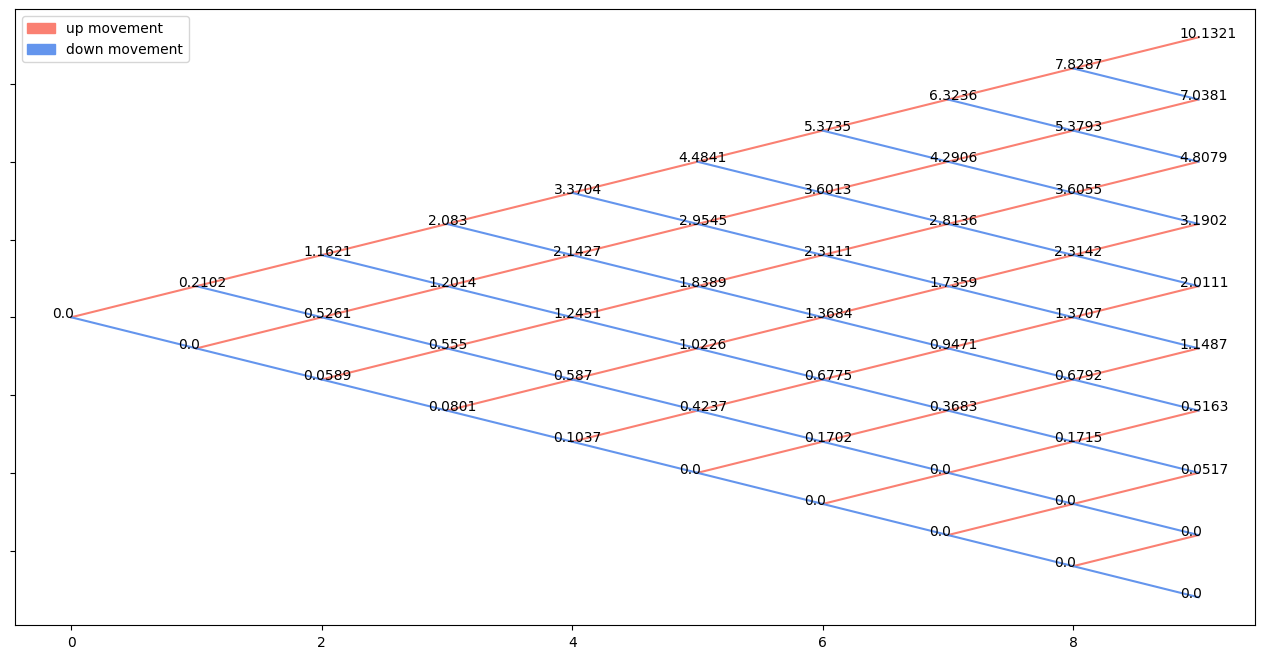

In [29]:
GraphTree(option_bdt.cash_flow(0.025,100,'cap')).fake_tree()
pd.DataFrame(option_bdt.cash_flow(0.025,100,'cap'))

##### Cash Flow, 5-year Cap: Panel B, p 392

,0,1,2,3,4,5,6,7,8,9
0,9.439293,12.188350,15.098409,17.349262,18.926982,19.438340,18.890260,17.286536,14.326108,9.096741
1,0.000000,6.855192,9.213803,11.251749,12.762027,13.423830,13.247467,12.249406,10.218269,6.499382
2,0.000000,0.000000,4.644180,6.450871,7.890378,8.680841,8.819973,8.328348,7.056781,4.533294
3,0.000000,0.000000,0.000000,2.841199,4.134290,5.003546,5.400162,5.317499,4.649563,3.054534
4,0.000000,0.000000,0.000000,0.000000,1.463428,2.242857,2.789242,3.028833,2.831127,1.947552
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.516212,0.924161,1.302093,1.465485,1.121766
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120999,0.232017,0.444320,0.507332
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012515,0.025249,0.051028
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


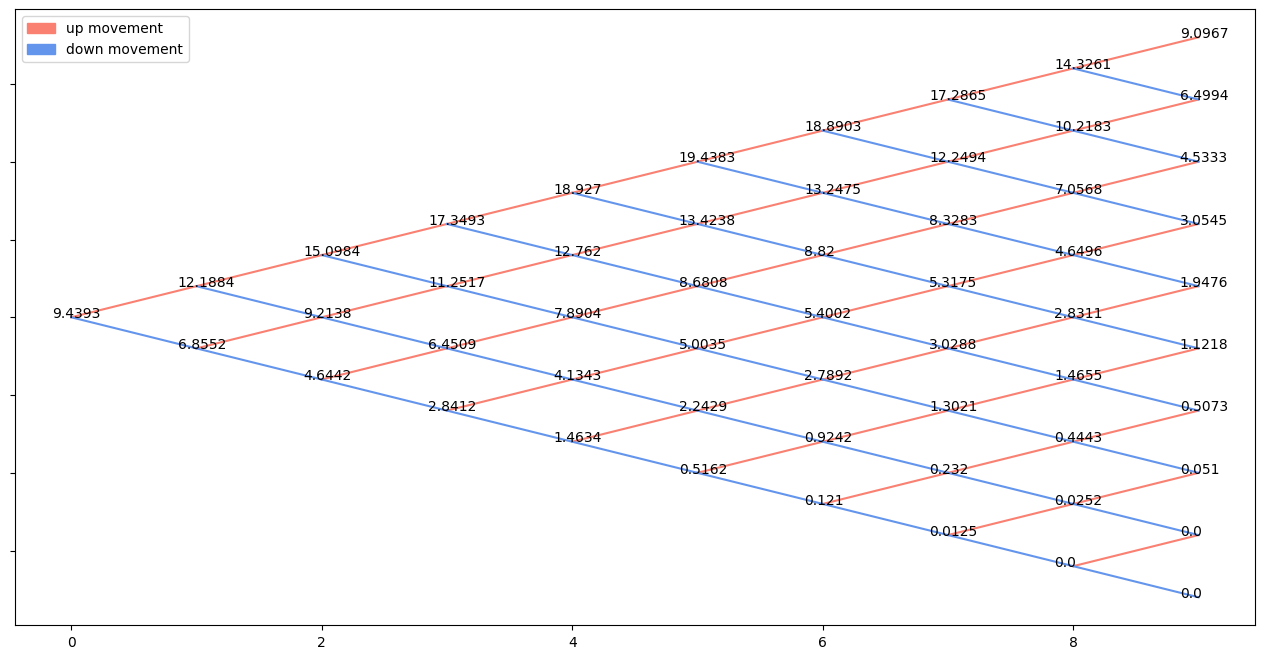

In [24]:
GraphTree(option_bdt.option(0.025,100,'cap')).fake_tree()
pd.DataFrame(option_bdt.option(0.025,100,'cap'))

Cash Flow - 5Y Swap Tree: Panel A: p 394

,0,1,2,3,4,5,6,7,8,9
0,-1.371231,-0.784779,0.167091,1.088010,2.375399,3.489088,4.378482,5.328552,6.833665,9.137145
1,0.000000,-1.168447,-0.468857,0.206369,1.147664,1.959517,2.606259,3.295568,4.384334,6.043055
2,0.000000,0.000000,-0.936066,-0.440026,0.250054,0.843918,1.316141,1.818607,2.610510,3.812917
3,0.000000,0.000000,0.000000,-0.914868,-0.407963,0.027552,0.373393,0.740930,1.319242,2.195160
4,0.000000,0.000000,0.000000,0.000000,-0.891296,-0.571306,-0.317457,-0.047928,0.375663,1.016063
5,0.000000,0.000000,0.000000,0.000000,0.000000,-1.011403,-0.824769,-0.626739,-0.315792,0.153673
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.197875,-1.052174,-0.823545,-0.478707
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.365280,-1.196974,-0.943308
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.471926,-1.285125
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.536870


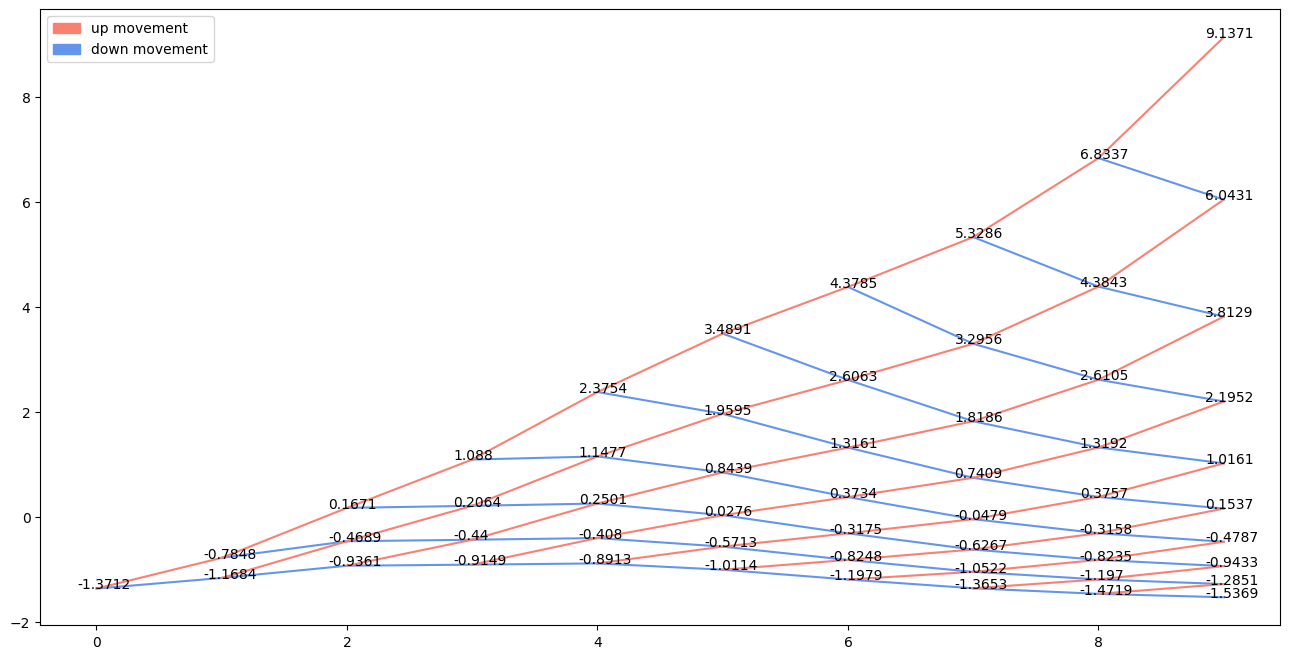

In [25]:
GraphTree(option_bdt.cash_flow(0.0449,100, "swap")).real_tree()
pd.DataFrame(option_bdt.cash_flow(0.0449,100, "swap"))

5Y - Swap Value Tree: Panel B: p 394

In [16]:
pd.DataFrame(option_bdt.fair_swap())

,0,1,2,3,4,5,6,7,8,9
0,-2.597431e-14,4.266413,8.183716,11.381237,13.862339,15.224889,15.500114,14.715964,12.585224,8.204431
1,0.000000e+00,-1.526202,2.041017,5.044557,7.480540,9.027730,9.715254,9.578343,8.416391,5.581576
2,0.000000e+00,0.000000,-2.791639,0.045441,2.440907,4.143350,5.178066,5.580019,5.208297,3.596188
3,0.000000e+00,0.000000,0.000000,-3.831919,-1.470584,0.357909,1.674516,2.510375,2.765778,2.102913
4,0.000000e+00,0.000000,0.000000,0.000000,-4.467708,-2.539433,-0.999787,0.177311,0.920777,0.985065
5,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-4.736601,-3.023723,-1.582764,-0.464760,0.151173
6,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-4.545787,-2.903283,-1.500770,-0.469292
7,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.889993,-2.272961,-0.930076
8,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.847159,-1.271792
9,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.524946


Table 11.9 - A 2-Year Payer Swaption

Example 11.6

,0,1,2,3,4
0,3.4067,5.112201,7.405990,10.327232,13.862339
1,0.0000,1.760732,2.967711,4.842028,7.480540
2,0.0000,0.000000,0.591663,1.198815,2.440907
3,0.0000,0.000000,0.000000,0.000000,0.000000
4,0.0000,0.000000,0.000000,0.000000,0.000000


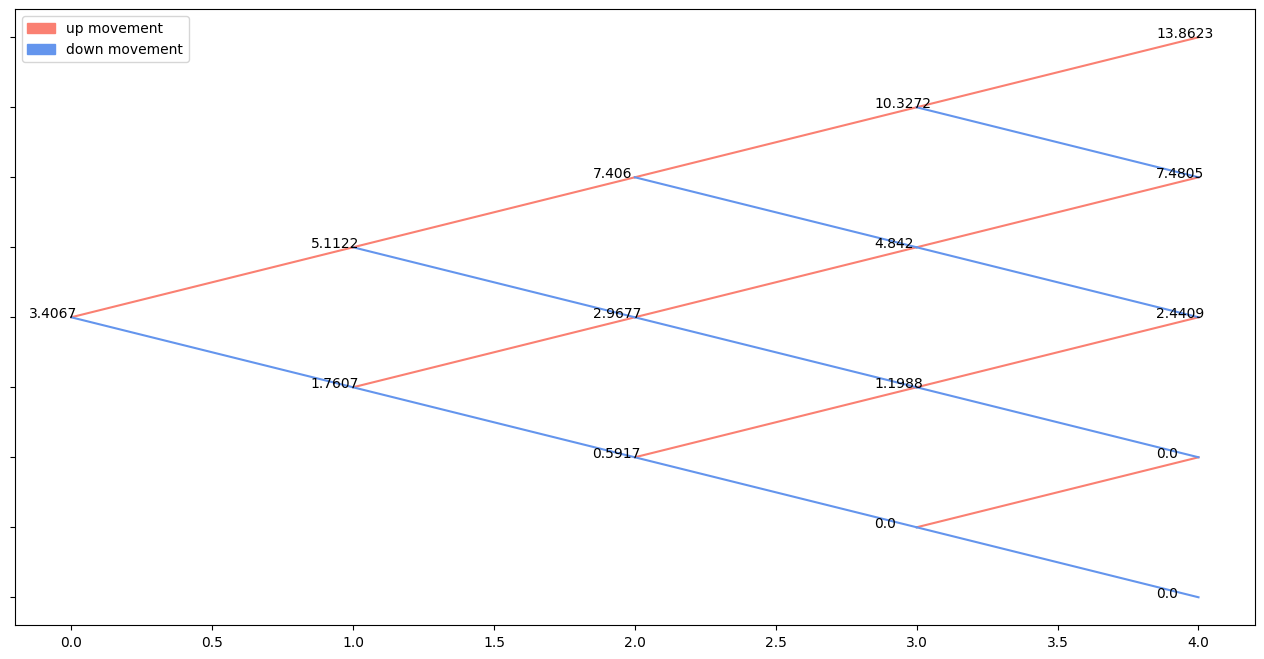

In [27]:
GraphTree(option_bdt.swaption(4)).fake_tree()
pd.DataFrame(option_bdt.swaption(4))

# Future ideas: 

- Code has been vectorised to avoid double loop. Nonetheless some part of the code could still be improved

- Try different solver

- Implement full Black Derman Toy model (not just the simple one)